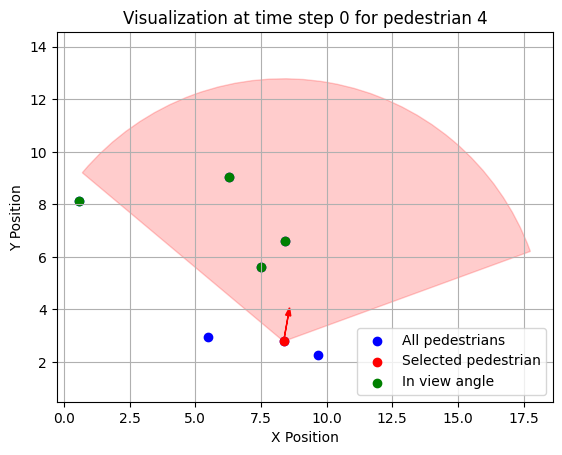

In [53]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Wedge

def calculate_directions(positions):
    velocities = positions[1:] - positions[:-1]
    if velocities.size(0) < positions.size(0):
        velocities = torch.cat([velocities, velocities[-1:].repeat(1, 1, 1)], dim=0)
    angles = torch.atan2(velocities[:, :, 1], velocities[:, :, 0])
    return angles

def filter_neighbors(positions, angles, view_angle=np.pi/2, tolerance=1e-2):
    T, N, _ = positions.shape
    adjacency_matrices = torch.zeros(T, N, N, dtype=torch.float)
    for t in range(T):
        for i in range(N):
            direction_i = angles[t, i]
            # 行人 i 的朝向向量
            heading_vector = torch.tensor([torch.cos(direction_i), torch.sin(direction_i)])
            for j in range(N):
                if i != j:
                    relative_position = positions[t, j] - positions[t, i]
                    # 计算有符号角度
                    cross_prod = heading_vector[0] * relative_position[1] - heading_vector[1] * relative_position[0]
                    dot_prod = heading_vector[0] * relative_position[0] + heading_vector[1] * relative_position[1]
                    angle_to_other = torch.atan2(cross_prod, dot_prod)
                    # 判断是否在视野范围内
                    if -view_angle - tolerance <= angle_to_other <= view_angle + tolerance:
                        adjacency_matrices[t, i, j] = 1
    return adjacency_matrices

def visualize_positions_with_view_cone(t, i, positions, adjacency_matrix, angles, view_angle=np.pi):
    fig, ax = plt.subplots()
    ax.scatter(positions[t, :, 0], positions[t, :, 1], color='blue', label='All pedestrians')
    ax.scatter(positions[t, i, 0], positions[t, i, 1], color='red', label='Selected pedestrian')

    direction = angles[t, i].item()
    radius = 10
    wedge = Wedge((positions[t, i, 0], positions[t, i, 1]), radius, 
                  np.degrees(direction - view_angle), np.degrees(direction + view_angle),
                  color='red', alpha=0.2)
    ax.add_patch(wedge)
    ax.arrow(positions[t, i, 0], positions[t, i, 1], 
             np.cos(direction), np.sin(direction), 
             head_width=0.2, head_length=0.3, fc='red', ec='red')

    for j in range(len(adjacency_matrix[t, i])):
        if adjacency_matrix[t, i, j] == 1:
            ax.scatter(positions[t, j, 0], positions[t, j, 1], color='green', label='In view angle')

    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    plt.legend(by_label.values(), by_label.keys())
    plt.xlabel('X Position')
    plt.ylabel('Y Position')
    plt.title(f'Visualization at time step {t} for pedestrian {i}')
    plt.grid(True)
    plt.axis('equal')
    plt.show()

# 生成数据
positions = torch.tensor(np.random.rand(5, 7, 2) * 10, dtype=torch.float32)  # T x N x 2
angles = calculate_directions(positions)
adjacency_matrices = filter_neighbors(positions, angles)

# 可视化第1个时间步的第5个行人的视角
visualize_positions_with_view_cone(0, 4, positions, adjacency_matrices, angles, view_angle=np.pi/3)


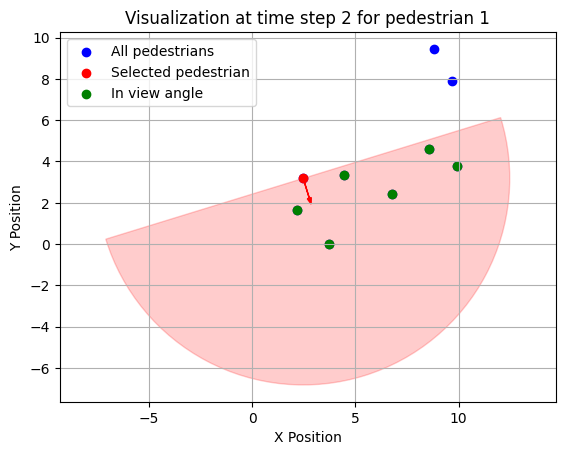

In [108]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Wedge

def calculate_directions(positions):
    T, N, _ = positions.size()
    velocities = torch.zeros_like(positions)
    velocities[1:] = positions[1:] - positions[:-1]
    # velocities[0] = velocities[1]  # 或者 velocities[0] = torch.zeros_like(velocities[0])
    velocities[0] = torch.zeros_like(velocities[0])
    angles = torch.atan2(velocities[:, :, 1], velocities[:, :, 0])
    return angles


def filter_neighbors(positions, angles, view_angle=np.pi/2, tolerance=1e-6):
    T, N, _ = positions.shape
    adjacency_matrices = torch.zeros(T, N, N, dtype=torch.float)
    for t in range(T):
        for i in range(N):
            direction_i = angles[t, i]
            heading_vector = torch.tensor([torch.cos(direction_i), torch.sin(direction_i)])
            for j in range(N):
                if i != j:
                    relative_position = positions[t, j] - positions[t, i]
                    cross_prod = heading_vector[0] * relative_position[1] - heading_vector[1] * relative_position[0]
                    dot_prod = heading_vector[0] * relative_position[0] + heading_vector[1] * relative_position[1]
                    angle_to_other = torch.atan2(cross_prod, dot_prod)
                    if -view_angle - tolerance <= angle_to_other <= view_angle + tolerance:
                        adjacency_matrices[t, i, j] = 1
    return adjacency_matrices

def visualize_positions_with_view_cone(t, i, positions, adjacency_matrix, angles, view_angle=np.pi/3):
    fig, ax = plt.subplots()
    ax.scatter(positions[t, :, 0], positions[t, :, 1], color='blue', label='All pedestrians')
    ax.scatter(positions[t, i, 0], positions[t, i, 1], color='red', label='Selected pedestrian')

    direction = angles[t, i].item()
    radius = 10
    wedge = Wedge((positions[t, i, 0].item(), positions[t, i, 1].item()), radius, 
                  np.degrees(direction - view_angle), np.degrees(direction + view_angle),
                  color='red', alpha=0.2)
    ax.add_patch(wedge)
    ax.arrow(positions[t, i, 0].item(), positions[t, i, 1].item(), 
             np.cos(direction), np.sin(direction), 
             head_width=0.2, head_length=0.3, fc='red', ec='red')

    for j in range(len(adjacency_matrix[t, i])):
        if adjacency_matrix[t, i, j] == 1:
            ax.scatter(positions[t, j, 0].item(), positions[t, j, 1].item(), color='green', label='In view angle')

    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    plt.legend(by_label.values(), by_label.keys())
    plt.xlabel('X Position')
    plt.ylabel('Y Position')
    plt.title(f'Visualization at time step {t} for pedestrian {i}')
    plt.grid(True)
    plt.axis('equal')
    plt.show()

# 使用您提供的数据
# np.random.seed(0)
positions = torch.tensor(np.random.rand(5, 9, 2) * 10, dtype=torch.float32)  # T x N x 2
angles = calculate_directions(positions)
adjacency_matrices = filter_neighbors(positions, angles, view_angle=np.pi/2)

# 可视化第1个时间步的第5个行人的视角
visualize_positions_with_view_cone(2, 1, positions, adjacency_matrices, angles, view_angle=np.pi/2)


In [1]:
import torch

def line_intersection(p1, p2, q1, q2):
    """计算两条直线 p1->p2 和 q1->q2 的交点，返回交点和参数t, s"""
    A = torch.tensor([
        [p2[0] - p1[0], q1[0] - q2[0]],
        [p2[1] - p1[1], q1[1] - q2[1]]
    ])
    b = torch.tensor([q1[0] - p1[0], q1[1] - p1[1]])
    try:
        ts = torch.linalg.solve(A, b)
        t, s = ts[0], ts[1]
        intersection = p1 + t * (p2 - p1)
        return intersection, t, s
    except RuntimeError:
        return None, None, None

def update_weights_with_intersections(positions, adjacency_matrices):
    T, N, _ = positions.shape
    weights = torch.zeros_like(adjacency_matrices)

    for t in range(T-1):
        for i in range(N):
            for j in range(i + 1, N):
                p1, p2 = positions[t, i], positions[t+1, i]
                q1, q2 = positions[t, j], positions[t+1, j]
                
                intersection, t_i, t_j = line_intersection(p1, p2, q1, q2)
                
                if intersection is not None and t_i is not None and t_j is not None:
                    # 计算距离和时间
                    dist_i = torch.norm(intersection - p1)
                    dist_j = torch.norm(intersection - q1)
                    v_i = torch.norm(p2 - p1)
                    v_j = torch.norm(q2 - q1)
                    
                    time_i = dist_i / v_i if v_i != 0 else torch.tensor(float('inf'))
                    time_j = dist_j / v_j if v_j != 0 else torch.tensor(float('inf'))

                    time_diff = torch.abs(time_i - time_j)
                    
                    # 避免除零错误
                    if time_diff == 0:
                        weight = torch.tensor(float('inf'))
                    else:
                        weight = 1.0 / (time_diff + 1e-6)
                    
                    weights[t, i, j] = weight
                    weights[t, j, i] = weight  # 确保矩阵的对称性

    return weights

In [2]:
# 示例位置数据
positions = torch.tensor([
    [[0.0, 0.0], [1.0, 1.0], [2.0, 2.0]],
    [[1.0, 0.0], [1.5, 2.0], [2.0, 4.0]], 
    [[2.0, 0.0], [2.5, 3.0], [3.0, 6.0]],  
    [[3.0, 0.0], [3.5, 4.0], [4.0, 8.0]], 
    [[4.0, 0.0], [4.5, 5.0], [5.0, 10.0]] 
], dtype=torch.float32)  # T x N x 2

# 初始化邻接矩阵
T, N, _ = positions.shape
adjacency_matrices = torch.ones((T, N, N)) - torch.eye(N)

# 计算权重
weights = update_weights_with_intersections(positions, adjacency_matrices)
print("Weights:\n", weights)

Weights:
 tensor([[[0.0000, 2.0000, 1.0000],
         [2.0000, 0.0000, 0.6667],
         [1.0000, 0.6667, 0.0000]],

        [[0.0000, 2.0000, 1.0000],
         [2.0000, 0.0000, 2.0000],
         [1.0000, 2.0000, 0.0000]],

        [[0.0000, 2.0000, 1.0000],
         [2.0000, 0.0000, 2.0000],
         [1.0000, 2.0000, 0.0000]],

        [[0.0000, 2.0000, 1.0000],
         [2.0000, 0.0000, 2.0000],
         [1.0000, 2.0000, 0.0000]],

        [[0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000]]])


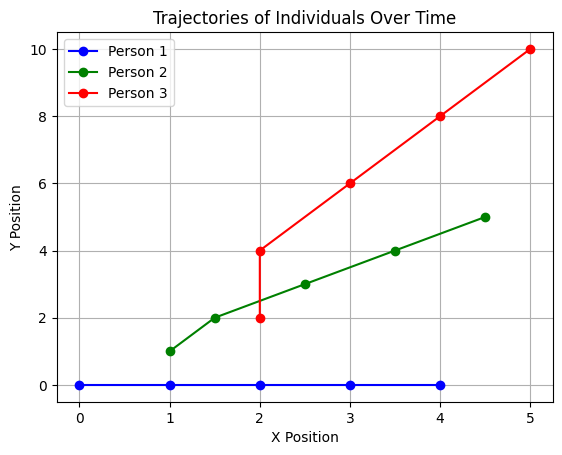

In [6]:
import torch
import matplotlib.pyplot as plt

# Sample position data
# positions = torch.tensor([
#     [[0.0, 0.0], [1.0, 1.0], [2.0, 2.0]],
#     [[1.0, 0.0], [1.5, 2.0], [2.0, 4.0]],  # 修改行人2的轨迹
#     [[2.0, 0.0], [2.5, 3.0], [3.0, 6.0]],  # 修改行人3的轨迹
#     [[3.0, 0.0], [3.5, 4.0], [4.0, 8.0]],  # 修改行人3的轨迹
#     [[4.0, 0.0], [4.5, 5.0], [5.0, 10.0]]  # 修改行人3的轨迹
# ], dtype=torch.float32)  # T x N x 2


# Number of entities
N = positions.size(1)

# Creating a plot
fig, ax = plt.subplots()
colors = ['blue', 'green', 'red']  # Colors for different trajectories

for i in range(N):
    # Extracting the trajectory for each person
    trajectory = positions[:, i, :].numpy()
    ax.plot(trajectory[:, 0], trajectory[:, 1], marker='o', color=colors[i], label=f'Person {i+1}')

# Setting up plot labels and title
ax.set_xlabel('X Position')
ax.set_ylabel('Y Position')
ax.set_title('Trajectories of Individuals Over Time')
ax.legend()
ax.grid(True)

# Show the plot
plt.show()


# 权重归一化

In [ ]:
def update_weights_with_intersections(positions, adjacency_matrices):
    T, N, _ = positions.shape
    weights = torch.zeros_like(adjacency_matrices)

    for t in range(T-1):
        for i in range(N):
            for j in range(i + 1, N):
                p1, p2 = positions[t, i], positions[t+1, i]
                q1, q2 = positions[t, j], positions[t+1, j]
                
                intersection, t_i, t_j = line_intersection(p1, p2, q1, q2)
                
                if intersection is not None and t_i is not None and t_j is not None:
                    dist_i = torch.norm(intersection - p1)
                    dist_j = torch.norm(intersection - q1)
                    v_i = torch.norm(p2 - p1)
                    v_j = torch.norm(q2 - q1)
                    
                    time_i = dist_i / v_i if v_i != 0 else torch.tensor(float('inf'))
                    time_j = dist_j / v_j if v_j != 0 else torch.tensor(float('inf'))

                    time_diff = torch.abs(time_i - time_j)
                    
                    weights[t, i, j] = 1.0 / (time_diff + 1e-6)
                    weights[t, j, i] = weights[t, i, j]

    # 归一化权重
    max_weight = weights.max()
    if max_weight > 0:
        weights /= max_weight

    return weights


# 权重sigmoid

In [8]:
def update_weights_with_intersections(positions, adjacency_matrices):
    T, N, _ = positions.shape
    weights = torch.zeros_like(adjacency_matrices)

    for t in range(T-1):
        for i in range(N):
            for j in range(i + 1, N):
                p1, p2 = positions[t, i], positions[t+1, i]
                q1, q2 = positions[t, j], positions[t+1, j]
                
                intersection, t_i, t_j = line_intersection(p1, p2, q1, q2)
                
                if intersection is not None and t_i is not None and t_j is not None:
                    dist_i = torch.norm(intersection - p1)
                    dist_j = torch.norm(intersection - q1)
                    v_i = torch.norm(p2 - p1)
                    v_j = torch.norm(q2 - q1)
                    
                    time_i = dist_i / v_i if v_i != 0 else torch.tensor(float('inf'))
                    time_j = dist_j / v_j if v_j != 0 else torch.tensor(float('inf'))

                    time_diff = torch.abs(time_i - time_j)
                    
                    # 使用 Sigmoid 函数调整权重
                    weight = 1 / (1 + torch.exp(time_diff))  # 将时间差的影响通过 Sigmoid 函数转换
                    
                    weights[t, i, j] = weight
                    weights[t, j, i] = weight  # 确保矩阵的对称性

    return weights


# 权重+距离

In [ ]:
def update_weights_with_intersections(positions, adjacency_matrices):
    T, N, _ = positions.shape
    weights = torch.zeros_like(adjacency_matrices)

    for t in range(T-1):
        for i in range(N):
            for j in range(i + 1, N):
                p1, p2 = positions[t, i], positions[t+1, i]
                q1, q2 = positions[t, j], positions[t+1, j]
                
                intersection, t_i, t_j = line_intersection(p1, p2, q1, q2)
                
                if intersection is not None and t_i is not None and t_j is not None:
                    dist_i = torch.norm(intersection - p1)
                    dist_j = torch.norm(intersection - q1)
                    v_i = torch.norm(p2 - p1)
                    v_j = torch.norm(q2 - q1)
                    
                    time_i = dist_i / v_i if v_i != 0 else torch.tensor(float('inf'))
                    time_j = dist_j / v_j if v_j != 0 else torch.tensor(float('inf'))

                    time_diff = torch.abs(time_i - time_j)
                    distance_factor = torch.exp(-torch.norm(intersection - p1) - torch.norm(intersection - q2))
                    
                    weight = 1.0 / (time_diff + 1e-6) * distance_factor
                    
                    weights[t, i, j] = weight
                    weights[t, j, i] = weight  # 确保矩阵的对称性

    return weights
